# AVISO data assimilation with correlated error reduction with 1-step approach

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import build_h_matrix, skill_matrix, inversion
from aviso_rossby_wave import build_swath, make_error_over_time
from aviso_rossby_wave import reverse_vector, forecast_ssh

## Starting Date

In [2]:
day0, day1 = 0, 6 # April 1st, 2017 # day0, day1 =  1856, 1857 July 1st, 2017
time_range = (day1 - day0) * 8
start_date = '2016-06-01' ## starting date
n_waves = '450' #number of waves

## Subset 10 degree by 10 degree of ocean

In [3]:
lonidx_west, lonidx_east  =  60, 100
latidx_south, latidx_north = 34, 74

In [4]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east,  :]

In [5]:
T_time = avisso_ds.time.data[day0:] * 86400 # time in seconds
date_time = avisso_ds.date_time.data[day0:]
date_time[0], avisso_ds.msla.shape, SSHA.shape # longtitude, latitude, time

(numpy.datetime64('2016-06-01T00:00:00.000000000'),
 (104, 184, 150),
 (40, 40, 150))

In [6]:
ssha_time_mean = SSHA.mean(axis = -1)

In [7]:
SSHA = SSHA - SSHA.mean(axis = -1) - SSHA.mean(axis = 0)

In [8]:
SSHA_masked = np.ma.masked_invalid(SSHA)

In [9]:
ssha_mask = np.ma.getmask(SSHA_masked)

In [10]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data

### Stratification paramters

In [11]:
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters to degrees
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N
g = 9.81 # gravity 

### Inversion with selecetd swath data points

In [12]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

In [13]:
Psi = strat_ds.Psi.data
MModes = 1
wavespeed = strat_ds.C2[:MModes].data  #np.array([Rm * f0])


### the aviso data is sampled at 5-day intervals

#### Rossby wave estimate

In [14]:
wave_ds = xr.open_dataset('./rossby_wave_estimate_' + start_date +'_' + n_waves + 'waves.nc')

#### Rossby deformation radius

In [15]:
k_n_orig, l_n_orig = wave_ds.k_n.data, wave_ds.l_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
Rm = wave_ds.Rm.data

In [16]:
k_n = k_n_orig.reshape(len(k_n_orig), MModes)
l_n = l_n_orig.reshape(len(l_n_orig), MModes)

In [17]:
MSLA0 = MSLA_fwd[:, :, day0:day1]

In [18]:
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time)
M = skill.size # number of models/waves

100%|█████████████████████████████████████████| 450/450 [00:11<00:00, 40.52it/s]


#### Build basis function H matrix

In [19]:
MModes = 1
H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
H_all = np.zeros([len(SSHA_vector), M * 2])
freq_n = np.zeros([M, MModes])

dlon = lon - lon.mean()
dlat = lat - lat.mean()

count = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            freq_n[count, mm] =  -1 * (Beta * k_n[kk]) / (k_n[kk] ** 2 + l_n[ll] ** 2 + Rm ** (-2))
            count += 1
nn = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            for count in range(len(Iindex)):
                H_cos[count, nn] = Psi[0, mm] * np.cos(l_n[ll] * dlon[int(Iindex[count])] + k_n[kk] * dlat[int(Jindex[count])] + freq_n[nn] * T_time[int(Tindex[count])])  
                H_sin[count, nn] = Psi[0, mm] * np.sin(l_n[ll] * dlon[int(Iindex[count])] + k_n[kk] * dlat[int(Jindex[count])] + freq_n[nn] * T_time[int(Tindex[count])])
            nn += 1

#### Build basis function H matrix

In [20]:
H_all[:, 0::2] = H_cos 
H_all[:, 1::2] = H_sin

#### build satellite swath

In [21]:
swath_width, x_swath = 6, 20
days = np.arange(day0, day1) # np.array([0, 1]) #range(day0, day1)
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_swath, days, lon, lat)

In [22]:
print(days)

[0 1 2 3 4 5]


#### Add errors to the swaths

In [23]:
time_factor = np.arange(1, 7)
time_factor 

array([1, 2, 3, 4, 5, 6])

In [24]:
alpha_base = time_factor * 1e-2# baseline dialation error parameter
alpha_roll = time_factor * -.5e-2 #  np.arange(1, len(day)) # roll error parameter
alpha_timing =  time_factor * .5e-7 # timing error parameter, set to be much smaller than others
alpha_phase3, alpha_phase4, alpha_phase5, alpha_phase6 = time_factor * 4e-3, time_factor * 3e-3, time_factor* 2e-3, time_factor * 1e-3
alpha = np.stack([alpha_timing,  alpha_roll, alpha_base, alpha_phase3, alpha_phase4, alpha_phase5, alpha_phase6])
#alpha = [alpha_timing,  alpha_roll, alpha_base, alpha_phase3, alpha_phase4, alpha_phase5, alpha_phase6]
timing_err_valid, roll_err_valid, baseline_dilation_err_valid, phase_err_valid, xc1_valid, xc2_valid  = make_error_over_time(days, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

6 40 6
450


In [25]:
alpha.shape

(7, 6)

In [26]:
timing_err_valid.shape, roll_err_valid.shape, baseline_dilation_err_valid.shape, phase_err_valid.shape, xc1_valid.shape, xc2_valid.shape

((6, 450), (6, 450), (6, 450), (6, 450), (6, 450), (6, 450))

#### sample SSH, errors and add white noise 

In [27]:
IND_TIMING = -7
IND_ROLL = -6
IND_BASELINE = -5
IND_PHASE3, IND_PHASE4, IND_PHASE5, IND_PHASE6 = -4, -3, -2, -1

In [28]:
N = len(xvalid_index)
N

2700

In [29]:
# number of valid data points
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v = np.zeros([N, 2 * M + 7]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
cor_err = np.zeros(N) # Correlated Error N: Number of y data
Y_v = np.zeros(N)
ssh = np.zeros(N)
xc = (swath_width - 1) / 2

count = 0
Tdim, Valid_points = timing_err_valid.shape # dimensions: time, valid points
for ii in range(Valid_points):
    IIndex[count] = ny * xvalid_index[ii] + yvalid_index[ii]
    for tt in range(Tdim):
        cor_err[count] = timing_err_valid[tt, ii]+ roll_err_valid[tt, ii] + baseline_dilation_err_valid[tt, ii] + phase_err_valid[tt, ii]
        # timing error = alpha[0] * Xc^0
        H_v[count, IND_TIMING] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
        # roll error = alpha[1] * Xc^1
        H_v[count, IND_ROLL] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
        # baseline dialation error = alpha[2] * Xc^2
        H_v[count, IND_BASELINE] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
        # phase error 
        H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
        H_pos = np.heaviside(xc1_valid[tt, ii], 1) # 
        # print(H_neg, H_pos)
        H_v[count, IND_PHASE3] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
        H_v[count, IND_PHASE4] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
        H_v[count, IND_PHASE5] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
        H_v[count, IND_PHASE6] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)
    
    ssh[count] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
    Y_v[count] =  cor_err[ii]  + ssh[ii] # + np.random.rand(1)/400
    for nn in range(M):
        JIndex = 2 * MModes * nn
        H_v[count, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_v[count, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]
    
    count += 1

In [30]:
Tdim, Valid_points = timing_err_valid.shape # dimensions: time, number of valid data points
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v = np.zeros([Tdim, Valid_points, 2 * M + 7]) # M: number of model
IIndex = np.zeros(Valid_points) # N: Number of y data
cor_err = np.zeros([Tdim, Valid_points]) # Correlated Error N: Number of y data
Y_v = np.zeros([Tdim, Valid_points])
ssh = np.zeros([Tdim, Valid_points])
xc = (swath_width - 1) / 2

for ii in range(Valid_points):
    IIndex[ii] = ny * xvalid_index[ii] + yvalid_index[ii]
    for tt in range(Tdim):
        cor_err[tt, ii] = timing_err_valid[tt, ii]+ roll_err_valid[tt, ii] + baseline_dilation_err_valid[tt, ii] + phase_err_valid[tt, ii]
        # timing error = alpha[0] * Xc^0
        H_v[tt, ii, IND_TIMING] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
        # roll error = alpha[1] * Xc^1
        H_v[tt, ii, IND_ROLL] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
        # baseline dialation error = alpha[2] * Xc^2
        H_v[tt, ii, IND_BASELINE] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
        # phase error 
        H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
        H_pos = np.heaviside(xc1_valid[tt, ii], 1) # 
        # print(H_neg, H_pos)
        H_v[tt, ii, IND_PHASE3] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
        H_v[tt, ii, IND_PHASE4] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
        H_v[tt, ii, IND_PHASE5] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
        H_v[tt, ii, IND_PHASE6] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)
    
        ssh[tt, ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
        Y_v[tt, ii] =  cor_err[tt, ii]  + ssh[tt, ii] # + np.random.rand(1)/400
        for nn in range(M):
            JIndex = 2 * MModes * nn
            H_v[tt, ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
            H_v[tt, ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

### 1-step approach: Solve for amplitudes and errors together

#### signal to noise ratio

In [31]:
counter = 0
exp = 1
alpha_factor = 1e1
kl = np.zeros(2 * M)
P_over_R = np.zeros([Tdim, 2 * M + 7, 2 * M + 7])
for tt in range(Tdim):
    P_over_R[tt, IND_TIMING, IND_TIMING] = alpha[IND_TIMING, tt] * alpha_factor #** 2 # timing error
    P_over_R[tt, IND_ROLL, IND_ROLL] = alpha[IND_ROLL, tt] ** 2 *  alpha_factor #** 2 # roll error
    P_over_R[tt, IND_BASELINE, IND_BASELINE] = alpha[IND_BASELINE, tt]*  alpha_factor #** 2 # baseline dilation error
    P_over_R[tt, IND_PHASE3, IND_PHASE3] = alpha[IND_PHASE3, tt] *  alpha_factor # ** 2 # phase error 1
    P_over_R[tt, IND_PHASE4, IND_PHASE4] = alpha[IND_PHASE4, tt]* alpha_factor  # ** 2 # phase error 2
    P_over_R[tt, IND_PHASE5, IND_PHASE5] = alpha[IND_PHASE5, tt] * alpha_factor # ** 2 # phase error 3
    P_over_R[tt, IND_PHASE6, IND_PHASE6] = alpha[IND_PHASE6, tt] *  alpha_factor  # ** 2 # phase error 4

for kk in k_n:
    for ll in l_n:
        kl[counter] = np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        P_over_R[tt, 2 * counter, 2 * counter] = kl[counter] ** exp
        P_over_R[tt, 2 * counter + 1, 2 * counter + 1] = kl[counter] ** exp
        counter += 1 

In [32]:
amp_1step,  ssh_estimated_swath = np.zeros([Tdim, 2 * M + 7]), np.zeros([Tdim, Valid_points])
for tt in range(Tdim):
    amp_1step[tt], ssh_estimated_swath[tt] = inversion(Y_v[tt], H_v[tt], P_over_R[tt])

#### One approach sanity check: fit errors to seven error basis functions

In [33]:
H_v[-7:, -7:].shape, P_over_R[-7:, -7:].shape, cor_err.shape, H_v[:, :].shape

((6, 7, 907), (6, 7, 907), (6, 450), (6, 450, 907))

In [34]:
amp_err_only,  err_estimated_swath = np.zeros([Tdim, 7]), np.zeros([Tdim, Valid_points])
for tt in range(Tdim):
    amp_err_only[tt], err_estimated_swath[tt] = inversion(cor_err[tt], H_v[tt, :, -7:], P_over_R[tt, -7:, -7:])

In [55]:
amp_diff_1step = amp_1step[:, -7:] - alpha.T
amp_diff_err_only = amp_err_only[:, -7:] - alpha.T

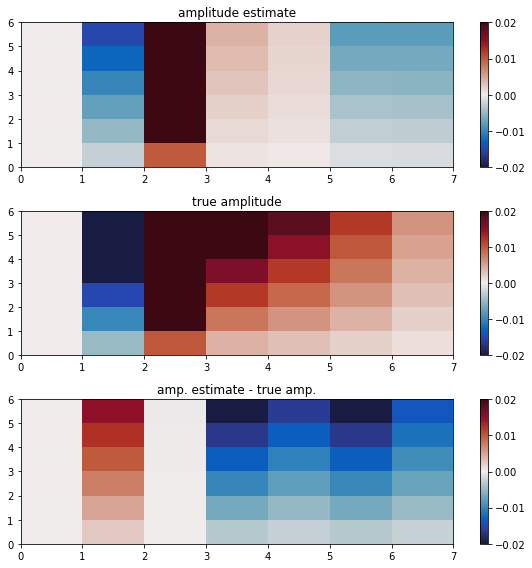

In [63]:
plt.figure(figsize = (8, 8 ))
plt.subplot(311)
plt.title('amplitude estimate')
plt.pcolormesh(amp_1step[:, -7:],  vmin = -.02, vmax= .02 ,cmap=cmo.cm.balance)
plt.colorbar()

plt.subplot(312)
plt.title('true amplitude')
plt.pcolormesh(alpha.T, vmin = -.02, vmax= .02, cmap=cmo.cm.balance)
plt.colorbar()

plt.subplot(313)
plt.title('amp. estimate - true amp.')
plt.pcolormesh(amp_diff_1step,  vmin = -.02, vmax= .02 ,cmap=cmo.cm.balance)
plt.colorbar()


plt.tight_layout()
plt.savefig('amp_solution_varying.png')

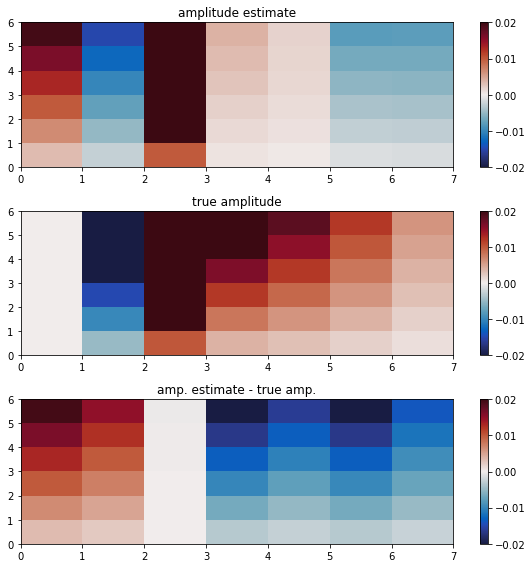

In [62]:
plt.figure(figsize = (8,8 ))
plt.subplot(311)
plt.title('amplitude estimate')
plt.pcolormesh(amp_err_only[:, -7:],  vmin = -.02, vmax= .02 ,cmap=cmo.cm.balance)
plt.colorbar()

plt.subplot(312)
plt.title('true amplitude')
plt.pcolormesh(alpha.T, vmin = -.02, vmax= .02, cmap=cmo.cm.balance)
plt.colorbar()

plt.subplot(313)
plt.title('amp. estimate - true amp.')
plt.pcolormesh(amp_diff_err_only,  vmin = -.02, vmax= .02 ,cmap=cmo.cm.balance)
plt.colorbar()


plt.tight_layout()
plt.savefig('amp_solution_varying.png')

#### compare the training data (truth) to estimate

In [77]:
H_v.shape, amp_1step.shape, np.matmul(H_v[tt], amp_1step[tt]).shape, ssh.shape, cor_err.shape, ssh_estimated_swath[tt].shape

((6, 450, 907), (6, 907), (450,), (6, 450), (6, 450), (450,))

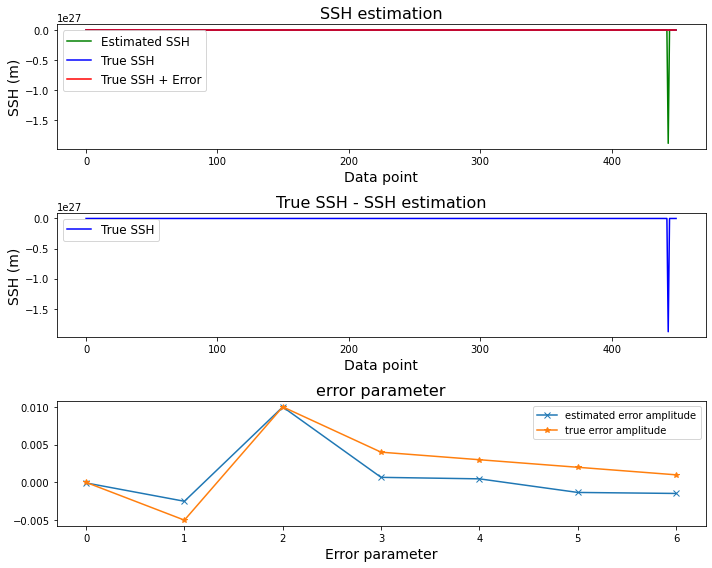

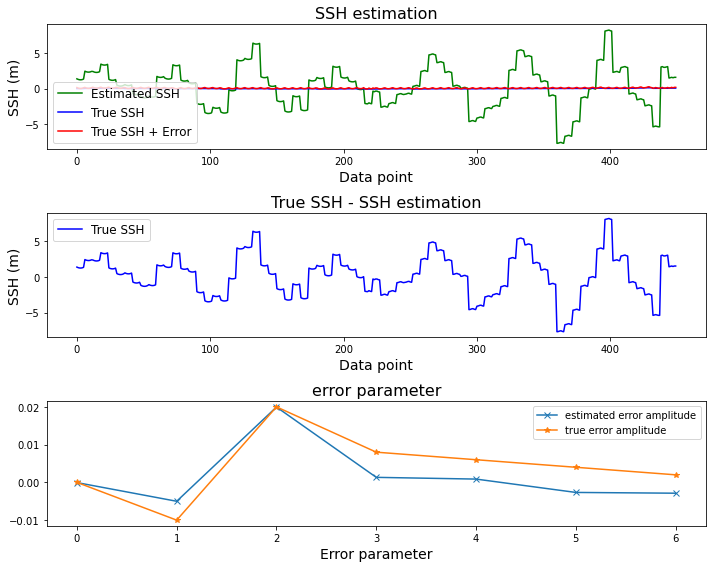

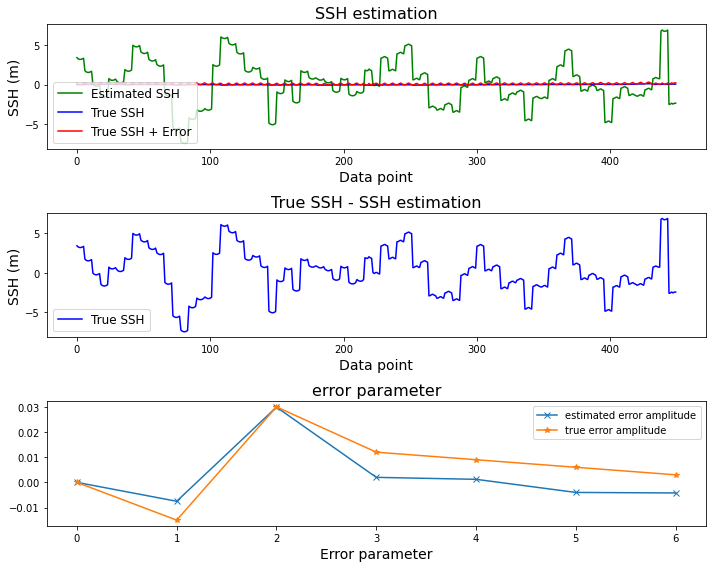

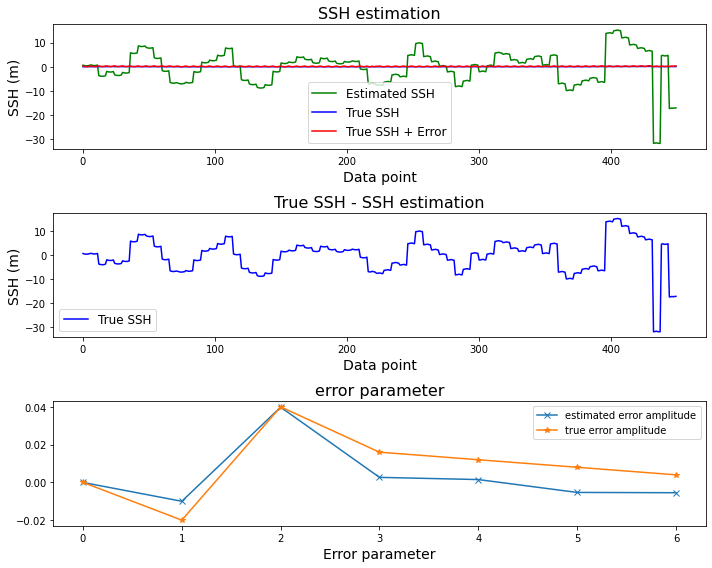

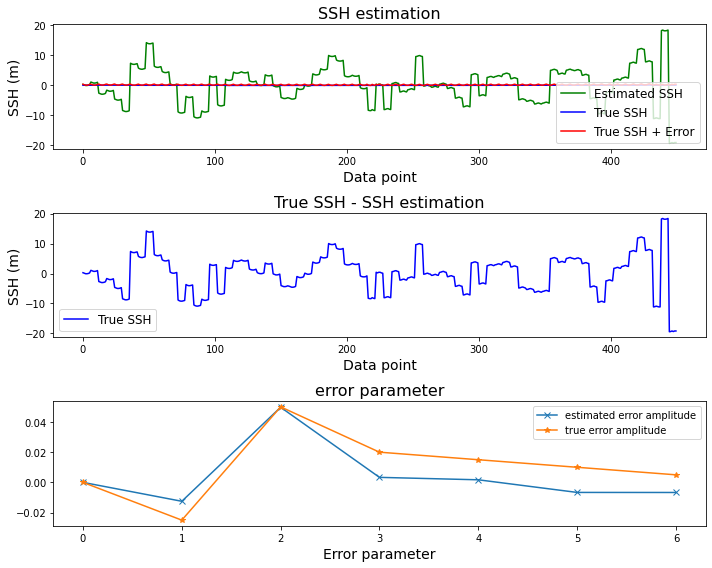

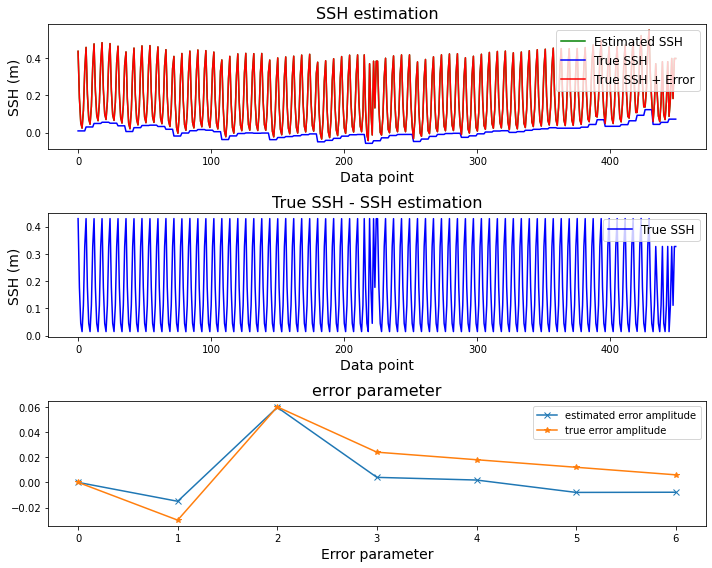

In [80]:
ssh_estimated_swath = np.zeros([Tdim, Valid_points])
for tt in range(Tdim):
    
    ssh_estimated_swath[tt] = np.matmul(H_v[tt], amp_1step[tt]) # estimated swath SSH-1 *
    ssh_diff[tt] = ssh_estimated_swath[tt] - ssh[tt]
    
    plt.figure(figsize=(10, 8))
    plt.subplot(311)
    plt.plot(ssh_estimated_swath[tt], 'green', label='Estimated SSH')
    plt.plot(ssh[tt], 'b', label='True SSH')
    plt.plot(ssh[tt] + cor_err[tt], 'r', label = 'True SSH + Error')
    #plt.xlabel('Distance along swath (km)', fontsize=14)
    plt.xlabel('Data point', fontsize=14)
    plt.ylabel('SSH (m)', fontsize=14)
    plt.title('SSH estimation', fontsize=16)
    plt.legend(fontsize=12)
    #plt.show()

    plt.subplot(312)
    #plt.plot(norm.pdf(ssh_diff, ssh_diff.mean(), ssh_diff.std()), '-', label='SSH difference')
    plt.plot(ssh_diff[tt], 'b', label='True SSH')
    plt.xlabel('Data point', fontsize=14)
    plt.ylabel('SSH (m)', fontsize=14)
    plt.title('True SSH - SSH estimation', fontsize=16)
    plt.legend(fontsize=12)

    plt.subplot(313)
    plt.title('error parameter', fontsize=16)
    plt.plot(amp_1step[tt, -7:], '-x', label = 'estimated error amplitude')
    plt.plot(alpha.T[tt], '-*', label = 'true error amplitude')
    plt.xlabel('Error parameter', fontsize=14)
    plt.legend()
    plt.tight_layout()
    
    plt.savefig('./ssh_err_estimate/ssh_err_parameter_'+  str(date_time[tt])[:10] +'.png')

In [73]:
from scipy.stats import norm
ssh_diff = ssh_estimated_swath - ssh

In [ ]:
plt.figure(figsize = (8, 5))
plt.subplot(211)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp_1step[:-7] ** 2  , '*', label = 'true amp')
plt.subplot(212)
plt.legend()

plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp ** 2 , '*', label = 'swath data')
plt.legend()

#### True and estimated SSH and Errors

In [ ]:
Y_hat = np.matmul(H_v, amp_1step)
err_est = np.matmul(H_v[:, -7:], amp_1step[-7:])
ssh_est = np.matmul(H_v[:, :-7], amp_1step[:-7])
err_map1 = np.zeros([len(lon), len(lat)])
ssh_map1 = np.zeros([len(lon), len(lat)])
ssh_true1 = np.zeros([len(lon), len(lat)])
err_true1 = np.zeros([len(lon), len(lat)])
lon_valid = np.ma.masked_all([len(lon), len(lat)])
lat_valid = np.ma.masked_all([len(lon), len(lat)])
for ii, idx in enumerate(xvalid_index):
    err_map1[xvalid_index[ii], yvalid_index[ii]] = err_est[ii] 
    ssh_map1[xvalid_index[ii], yvalid_index[ii]]  = ssh_est[ii]
    err_true1[xvalid_index[ii], yvalid_index[ii]] = cor_err[ii]
    ssh_true1[xvalid_index[ii], yvalid_index[ii]] = ssh[ii]
    lon_valid[xvalid_index[ii], yvalid_index[ii]] = lon[yvalid_index[ii]]
    lat_valid[xvalid_index[ii], yvalid_index[ii]] = lat[xvalid_index[ii]]

#### Reverse the vectorization on the swaths

In [ ]:
err_diff1 = np.sqrt(np.mean((err_true1 - err_map1) ** 2 ))/ np.sqrt(np.mean((err_true1) ** 2 ))
ssh_diff1 = np.sqrt(np.mean((ssh_true1 - ssh_map1) ** 2 ))/ np.sqrt(np.mean((ssh_true1) ** 2 ))
ssh_diff1, err_diff1, #ssh_map1

In [ ]:
fig = plt.figure(figsize = (10, 12))


plt.subplot(321)
plt.pcolormesh(lon, lat, err_true1 + ssh_true1, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) True error + true SSH', fontsize = 14)


plt.subplot(323)
plt.pcolormesh(lon, lat, ssh_map1, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) SSH estimate, 1-step ' + str((1- ssh_diff1) * 100)[:5] + '%', fontsize = 14)

plt.subplot(325)
plt.pcolormesh(lon, lat, ssh_true1 - ssh_map1, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('e) True SSH - SSH estimate, ' + str(ssh_diff1 * 100)[:5] + '%', fontsize = 14)


plt.subplot(322)
plt.pcolormesh(lon, lat, err_true1, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('b) True error', fontsize = 14)

plt.subplot(324)
plt.pcolormesh(lon, lat, err_map1, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('d) Error estimate ' +  str((1- err_diff1) * 100)[:4] + '%', fontsize = 14)

plt.subplot(326)
plt.pcolormesh(lon, lat, err_true1 - err_map1, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('f) True Error - Error estimate, ' + str(err_diff1 * 100)[:4] + '%' , fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_ssh_estimate_'+ str(date_time[0])[:10] + '_1step_' + str(int(day1 - day0)*5) +'day.png', dpi = 300)

#### Make predictions of SSH based on the estimated amplitudes:
#### is the extrapolation skill good?

In [ ]:
#time_range = 8 ## 8 * 5 = 40 days
SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
residual_iter = np.zeros(time_range)
MSLA_inverse = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
for day in range(0, time_range):
    #print(date_time[day])
    MSLA = MSLA_fwd[:, :, day : day+1]  #day : day + day1 - day0
    H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day)
    SSHA_predicted[day], SSHA_true[day], residual_iter[day] = forecast_ssh(MSLA, amp_1step[:-7], H_all) #MSLA, amp, H_all
    MSLA_inverse[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
#     plt.figure(figsize = (15, 5))

#     plt.subplot(131)
#     plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) #MSLA_fwd[:, :, day]
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('a) AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

#     plt.subplot(132)
#     #plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')
    
#     plt.pcolormesh(lon, lat, MSLA_inverse[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('b) 1-step inversion, swath data', fontsize = 14)

#     residual = MSLA[:, :, 0] - MSLA_inverse[:, :, day] 
#     plt.subplot(133)
#     plt.plot(lon_valid, lat_valid, 'x', color = 'gray')
#     plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('c) Residual variance ' +  str(residual_iter[day] * 100)[:4] + '%', fontsize = 14)
    
#     plt.tight_layout()
#     #plt.close()
#     plt.savefig('ssh_1step_' + str(date_time[day])[:10] +'_2_err_' + str(skill.size) + 'waves.png', dpi = 300)

In [ ]:
residual_iter

In [ ]:
#persistence = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0+6:day0+7]
persistence = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0:day0+1]
prediction_err = MSLA_inverse[:, :, :time_range] - MSLA_fwd[:, :, :time_range]
rms_persistence = np.zeros(persistence.shape[-1])
rms_prediction_err = np.zeros(prediction_err.shape[-1])
for t in range(persistence.shape[-1]):
    #rms_persistence_err[t] = np.sqrt(np.mean(persistence_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, 0:1].data ** 2))
    rms_persistence[t] = np.sqrt(np.mean(persistence[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, 0:1].data ** 2))
    rms_prediction_err[t] = np.sqrt(np.mean(prediction_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, t].data ** 2))

plt.figure(figsize = (10,10))
plt.subplot(211)
plt.plot(time[:time_range],  rms_prediction_err[:time_range] * 100,  
         '-*',linewidth = 2, color = 'r', label = 'Estimate error')
#plt.plot(time[:time_range], residual_iter*100)
plt.subplot(212)
plt.plot(time[:time_range],  rms_prediction_err[:time_range] * 100,  
         '-*',linewidth = 2, color = 'r', label = 'Estimate error')
plt.plot(time[:time_range], rms_persistence[:time_range] * 100,  
         '-x', linewidth = 2, color = 'k', label = 'Persistence' )
#plt.plot(T_time[:time_range][0::2]/86400, np.repeat(100, len(time)),linestyle = '--',  color = 'y')
#plt.xticks(time[:time_range][0::2]/86400, time[:time_range][0::2] - time[0])
plt.ylabel('Percentage (%)', fontsize = 13)
plt.xlabel('time (days)', fontsize = 13)
plt.legend()
plt.tight_layout()
plt.savefig('./prediction_vs_persistence/prediction_err_vs_persistence_' + str(M) + '_waves_2errs.png', dpi = 300)

### One approach sanity check: fit errors to seven error basis functions

#### construct H matrix with only error basis funcstons

In [ ]:
count = 0
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v1 = np.zeros([N, 7]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
Y_v, cor_err, ssh = np.zeros(N), np.zeros(N), np.zeros(N)
for ii in range(len(xvalid_index)):
    IIndex[ii] = ny * xvalid_index[ii] + yvalid_index[ii]
    #IIndex[ii] = nx * yvalid_index[ii] + xvalid_index[ii]
    cor_err[ii] = timing_err_valid[ii]+ roll_err_valid[ii] + baseline_dilation_err_valid[ii] + phase_err_valid[ii]
    ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
    
    # Only fit errors! 
    Y_v[ii] =  cor_err[ii]  #+ ssh[ii]  #
    
    H_v1[ii, IND_TIMING] = 1 # timing error = alpha[0] * X^0 
    H_v1[ii, IND_ROLL] = xc1_valid[ii] # roll error = alpha[1] * X^1
    H_v1[ii, IND_BASELINE] = xc2_valid[ii] # baseline dialation error = alpha[2] * X^2
    H_neg = np.heaviside(-1 * xc1_valid[ii], 1) 
    H_pos = np.heaviside(xc1_valid[ii], 1)
    
    # phase error
    H_v1[ii, IND_PHASE3] = H_neg                 
    H_v1[ii, IND_PHASE4] = xc1_valid[ii] * H_neg 
    H_v1[ii, IND_PHASE5] = H_pos                 
    H_v1[ii, IND_PHASE6] = xc1_valid[ii] * H_pos 

In [ ]:
P_over_R1 = np.eye(7, 7)
P_over_R1[IND_TIMING, IND_TIMING] = alpha[IND_TIMING] * alpha_factor #** 2 # timing error
P_over_R1[IND_ROLL, IND_ROLL] = alpha[IND_ROLL] *  alpha_factor #** 2 # roll error
P_over_R1[IND_BASELINE, IND_BASELINE] = alpha[IND_BASELINE]*  alpha_factor #** 2 # baseline dilation error
P_over_R1[IND_PHASE3, IND_PHASE3] = alpha[IND_PHASE3] *  alpha_factor #** 2 # phase error 1
P_over_R1[IND_PHASE4, IND_PHASE4] = alpha[IND_PHASE4]*  alpha_factor  #** 2 # phase error 2
P_over_R1[IND_PHASE5, IND_PHASE5] = alpha[IND_PHASE5] *  alpha_factor #** 2 # phase error 3
P_over_R1[IND_PHASE6, IND_PHASE6] = alpha[IND_PHASE6]*  alpha_factor  #** 2 # phase error 4

In [ ]:
HTH = np.matmul(H_v1.T, H_v1)

In [ ]:
HRH = HTH + P_over_R1 #0.81 * sigma #, P: uncertainty in model, R: uncertainty in data
D = np.matmul(LA.inv(HRH), H_v1.T)   

In [ ]:
amp_err = np.matmul(D, Y_v)
amp_err , alpha

In [ ]:
#### test: fit two errors with two error models
amp_2err_2model = np.matmul(D, cor_err)
amp_2err_2model ,  alpha

#### correlated error estimate

In [ ]:
#### estimate the correlated error
err_est = np.matmul(H_v1, amp_err)
#err_est

#### SSH + correlated errors - estimated correlated errors

In [ ]:
tau_ssh = Y_v - err_est

In [ ]:
err_map = np.zeros([len(lon), len(lat)])
ssh_true = np.zeros([len(lon), len(lat)])
ssh_1st_step = np.zeros([len(lon), len(lat)])
err_true = np.zeros([len(lon), len(lat)])
for ii, idx in enumerate(xvalid_index):
    err_map[yvalid_index[ii], xvalid_index[ii]] = err_est[ii] 
    ssh_true[yvalid_index[ii], xvalid_index[ii]] = ssh[ii]
    err_true[yvalid_index[ii], xvalid_index[ii]] = cor_err[ii]
    ssh_1st_step[yvalid_index[ii], xvalid_index[ii]] = tau_ssh[ii]

In [ ]:
ssh_diff_1st_step = np.sqrt(np.mean((ssh_true - ssh_1st_step) ** 2 ))/ np.sqrt(np.mean((ssh_true) ** 2 ))
ssh_diff_1st_step , str(ssh_diff_1st_step * 100)[:4] 

###  Ambiguity test 

#### basis function correlation matrix: assessing whether the basis functions are orthogonal

In [ ]:
import pandas as pd
import seaborn as sns
# collect data
data = H_v[:, -7:]
# form dataframe
dataframe = pd.DataFrame(data, columns=['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
cov_matrix = dataframe.cov()

In [ ]:
corr_matrix = dataframe.corr()

In [ ]:
H_v[:, -7:].shape, cov_matrix

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True, cmap = cmo.cm.balance, vmin = -1, vmax = 1)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
plt.yticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
plt.title('Basis Function Correlation Matrix', fontsize = 14)
plt.savefig('./H_corr_matrix.png')

#### the proterier covariance matrix of the difference between the estimated and the true model parameters is

In [ ]:
COV = LA.inv(HRH + LA.inv(P_over_R1))

In [ ]:
def correlation_from_covariance(covariance):
    
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    
    return correlation

In [ ]:
COR = correlation_from_covariance(COV)

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(COV, annot = True, cmap = cmo.cm.balance, vmin = -.05, vmax = .05)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
plt.yticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
plt.title('Model Parameter Covariance Matrix $<(x-\hat{x})(x-\hat{x})^T> = (H^{T}R^{-1}H + P^{-1})^{-1}$', fontsize = 14)
plt.savefig('./cov_matrix.png')

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(COR, annot = True, cmap = cmo.cm.balance, vmin = -.75, vmax = .75)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
plt.yticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
plt.title('Model Parameter Correlation Matrix $(H^{T}R^{-1}H + P^{-1})^{-1}$', fontsize = 14)
plt.savefig('./corr_matrix.png')

### Two-step approach: reconstructing the SSH separately from solving the correlated error

#### First step: fit errors

In [ ]:
count = 0
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v1 = np.zeros([N, 7]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
Y_v, cor_err, ssh = np.zeros(N), np.zeros(N), np.zeros(N)
for ii in range(len(xvalid_index)):
    IIndex[ii] = ny * xvalid_index[ii] + yvalid_index[ii]
    cor_err[ii] = roll_err_valid[ii] + baseline_dilation_err_valid[ii]
    ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
    Y_v[ii] =  cor_err[ii] + ssh[ii] # + np.random.rand(1)/10 
    H_v1[ii, IND_TIMING] = 1 
    H_v1[ii, IND_BASELINE] = xc1_valid[ii] 
    H_v1[ii, IND_ROLL] = xc2_valid[ii] 
    H_neg = np.heaviside(-1 * xc1_valid[ii], 1) 
    H_pos = np.heaviside(xc1_valid[ii], 1) 
    H_v[ii, IND_PHASE3] = H_neg                 
    H_v[ii, IND_PHASE4] = xc1_valid[ii] * H_neg 
    H_v[ii, IND_PHASE5] = H_pos                 
    H_v[ii, IND_PHASE6] = xc1_valid[ii] * H_pos 

In [ ]:
P_over_R1 = P_over_R[-7:, -7:]

In [ ]:
HTH = np.matmul(H_v1.T, H_v1)

In [ ]:
HRH = HTH + P_over_R1 #0.81 * sigma #, P: uncertainty in model, R: uncertainty in data
D = np.matmul(LA.inv(HRH), H_v1.T)   

In [ ]:
amp_err = np.matmul(D, Y_v)
amp_err[-7:] , alpha
#plt.plot(amp_err[-7:]) 
#plt.plot(alpha)

In [ ]:
#### test: fit two errors with two error models
amp_2err_2model = np.matmul(D, cor_err)
#plt.plot(amp_2err_2model) 
#plt.plot(alpha)

#### correlated error estimate

In [ ]:
#### estimate the correlated error
err_est = np.matmul(H_v1, amp_err)

#### SSH + correlated errors - estimated correlated errors

In [ ]:
tau_ssh = Y_v - err_est

In [ ]:
err_map = np.zeros([nx, ny])
ssh_true = np.zeros([nx, ny])
ssh_1st_step = np.zeros([nx, ny])
err_true = np.zeros([nx, ny])
for ii, idx in enumerate(xvalid_index):
    err_map[xvalid_index[ii], yvalid_index[ii]] = err_est[ii] #[Iindex[ii].astype(int)]
    ssh_true[xvalid_index[ii], yvalid_index[ii]] = ssh[ii]
    err_true[xvalid_index[ii], yvalid_index[ii]] = cor_err[ii]
    ssh_1st_step[xvalid_index[ii], yvalid_index[ii]] = tau_ssh[ii]

In [ ]:
ssh_diff_1st_step = np.sqrt(np.mean((ssh_true - ssh_1st_step) ** 2 ))/ np.sqrt(np.mean((ssh_true) ** 2 ))
ssh_diff_1st_step , str(ssh_diff_1st_step * 100)[:4] 

#### second step: fit residual to rossby wave models

In [ ]:
count = 0
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v = np.zeros([N, 2 * M ]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
Y_v = np.zeros(N)
for ii in range(len(xvalid_index)):
    IIndex[ii] = ny * xvalid_index[ii] + yvalid_index[ii]
    for nn in range(M):
        JIndex = 2 * MModes * nn #+  2 * mm # Model space
        H_v[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_v[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]   

In [ ]:
HTH = np.matmul(H_v.T, H_v)

In [ ]:
RR, PP = 10, 1
R_ = np.eye(N, N)
R_over_P = P_over_R[:2 * M, :2 * M]

In [ ]:
HRH = np.zeros(HTH.shape)
HRH = HTH +  R_over_P 

In [ ]:
D = np.matmul(LA.inv(HRH), H_v.T)
eig, vec = LA.eig(HRH)

#### Soution with noise, 2 step approach

In [ ]:
amp_swath_2step = np.matmul(D, tau_ssh)

#### Prediction with new amplitudes in the next 40 days

In [ ]:
ssh_est = np.matmul(H_v, amp_swath_2step)

In [ ]:
err_map = np.zeros([nx, ny])
ssh_true = np.zeros([nx, ny])
ssh_2step = np.zeros([nx, ny])
err_true = np.zeros([nx, ny])
for ii, idx in enumerate(xvalid_index):
    err_map[xvalid_index[ii], yvalid_index[ii]] = err_est[ii] 
    ssh_true[xvalid_index[ii], yvalid_index[ii]] = ssh[ii]
    err_true[xvalid_index[ii], yvalid_index[ii]] = cor_err[ii]
    ssh_2step[xvalid_index[ii], yvalid_index[ii]] = ssh_est[ii]

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
plt.plot(ssh_est, 'green', label='Estimated SSH, 2 step')
plt.plot(ssh, 'b', label='True SSH')
plt.plot(ssh + cor_err, 'r', label = 'True SSH + Error')
plt.xlabel('Data point', fontsize=14)
plt.ylabel('SSH (m)', fontsize=14)
plt.title('SSH estimation', fontsize=16)
plt.legend(fontsize=12)

ssh_diff = ssh - ssh_est

plt.subplot(312)
#plt.plot(norm.pdf(ssh_diff, ssh_diff.mean(), ssh_diff.std()), '-', label='SSH difference')
plt.plot(ssh_diff, 'b', label='True SSH')
plt.xlabel('Data point', fontsize=14)
plt.ylabel('SSH (m)', fontsize=14)
plt.title('True SSH - SSH estimation', fontsize=16)
plt.legend(fontsize=12)

plt.subplot(313)
plt.title('error parameter', fontsize=16)
plt.plot(amp_err, '-x', label = 'estimated error amplitude, 2 step')
plt.plot(alpha, '-*', label = 'true error amplitude')
plt.xlabel('Error parameter', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('./ssh_err_parameter_2step.png')

In [ ]:
ssh_diff_2step = np.sqrt(np.mean((ssh_true - ssh_2step) ** 2 ))/ np.sqrt(np.mean((ssh_true) ** 2 ))
err_diff_2step = np.sqrt(np.mean((err_true - err_map) ** 2 ))/ np.sqrt(np.mean((err_true) ** 2 ))
ssh_diff_2step , str(ssh_diff_2step * 100)[:4], err_diff_2step

In [ ]:
fig = plt.figure(figsize = (10, 12))


plt.subplot(321)
plt.pcolormesh(lon, lat, err_true1 + ssh_true1, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) True error + true SSH', fontsize = 14)


plt.subplot(323)
plt.pcolormesh(lon, lat, ssh_2step, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) SSH estimate, 2-step,  ' + str((1- ssh_diff_2step) * 100)[:5] + '%', fontsize = 14)

plt.subplot(325)
plt.pcolormesh(lon, lat, ssh_true - ssh_2step, cmap = cmo.cm.balance, vmin = -.1, vmax = .1)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('e) True SSH - SSH estimate, ' + str(ssh_diff_2step * 100)[:4]  + '%', fontsize = 14)


plt.subplot(322)
plt.pcolormesh(lon, lat, err_true, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('b) True error', fontsize = 14)

plt.subplot(324)
plt.pcolormesh(lon, lat, err_map, cmap = cmo.cm.balance, vmin = -.1, vmax = .1)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('d) Error estimate, '+ str((1- err_diff_2step) * 100)[:5] + '%', fontsize = 14)

plt.subplot(326)
plt.pcolormesh(lon, lat, err_true - err_map, cmap = cmo.cm.balance, vmin = -.1, vmax = .1)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('f) True Error - Error estimate, ' + str(err_diff_2step * 100)[:4] + '%' , fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_ssh_estimate_'+ str(date_time[0])[:10] + '_2step.png', dpi = 300)

In [ ]:
time_range = 8 ## 8 * 5 = 40 days
SSHA_predicted = np.zeros([time_range, MSLA.size])
SSHA_true = np.zeros([time_range, MSLA.size])
residual_iter = np.zeros(time_range)
MSLA_inverse = np.zeros([MSLA.shape[0], MSLA.shape[1], time_range])
for day in range(time_range):
    MSLA = MSLA_fwd[:, :, day:day+1]
    SSHA_predicted[day], SSHA_true[day], residual_iter[day] = forecast_ssh( MSLA, amp_swath_2step, H_all)
    MSLA_inverse[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
#     plt.figure(figsize = (15, 5))

#     plt.subplot(131)
#     plt.pcolormesh(lon, lat, MSLA_fwd[:, :, day], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('a) AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

#     plt.subplot(132)
#     plt.pcolormesh(lon, lat, MSLA_inverse[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('b) 2-step inversion, swath data', fontsize = 14)

#     residual =   MSLA_fwd[:, :, day] - MSLA_inverse[:, :, day]
#     plt.subplot(133)
#     plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     #plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')
#     plt.plot(lon_valid, lat_valid , 'x', color = 'gray')
#     plt.title('c) Residual variance ' + str(residual_iter[day] * 100)[:4] + '%', fontsize = 14)

#     plt.tight_layout()
#     plt.savefig('inversion_2step_' + str(date_time[day])[:10] +'_with_corr_err_' + str(skill.size) + 'waves_2step.png', dpi = 100)